In [1]:
from lib.puzzles_generator_MET import prepare_data_p, prepare_data_v, prepare_fragments
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [2]:
data_p = prepare_data_p('/home/david/Bases/met/', fragment_per_side=3, fragment_size=64, space=8, batch_size=1, data_aug=False, phase='val')

puzzle size 288


[6]


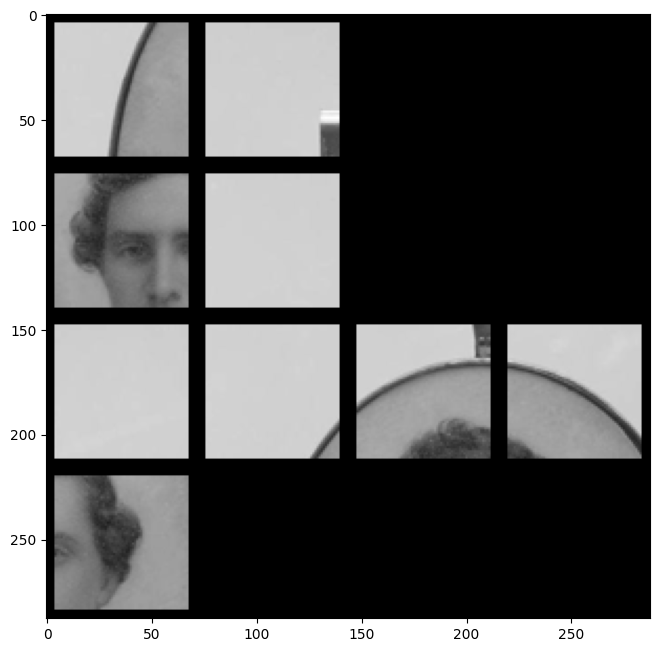

In [3]:
img, label, mask = data_p[0]
img = img.transpose(1,2,0).squeeze()
img = (img - np.min(img))/np.ptp(img)
print(label)
plt.imshow(img)

In [4]:
mask

array([[[1., 1., 1., 1.],
        [1., 1., 0., 0.],
        [1., 1., 1., 1.],
        [1., 0., 0., 0.]]])

In [5]:
data_v = prepare_data_v('/home/david/Bases/met/', fragment_per_side=3, fragment_size=64, space=8, batch_size=1, phase='val', nb_helpers=1, data_aug=False)

[0]


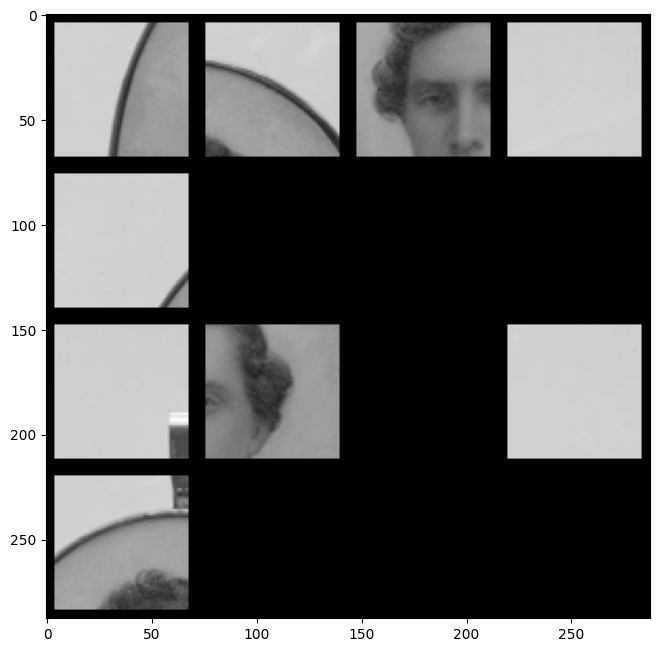

In [6]:
x, label, mask = data_v[0]
img = x.transpose(1,2,0).squeeze()
img = (img - np.min(img))/np.ptp(img)
print(label)
plt.imshow(img)

In [7]:
mask

array([[[1., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 1., 0., 1.],
        [1., 0., 0., 0.]]])

In [8]:
import observable_state, reassembly, game

In [9]:
args = {
    'dir_global': '/home/david/Bases/met/', 
    'puzzle_size': 72*3, 
    'fragment_per_side': 3, 
    'fragment_size': 64, 
    'space_size': 8,
    'fragments_nb': 9
}
g = game.Game(args['puzzle_size'], args['fragment_size'], args['fragments_nb'], space=args['space_size'])
fragments_loader = prepare_fragments(path=args['dir_global'], phase='val',
                                  puzzle_size=args['puzzle_size'], fragment_per_side=args['fragment_per_side'],
                                  fragment_size=args['fragment_size'], space=args['space_size'])

In [10]:
g = game.Game(args['puzzle_size'], args['fragment_size'], args['fragments_nb'], space=args['space_size'])
fragments, solution_dicts = fragments_loader.prepare_problem(0)
print(solution_dicts)
for i in range(0, args['fragments_nb']):
    solution_dicts[i]['position'] = -1

[{'idx': 0, 'position': 1}, {'idx': 1, 'position': 5}, {'idx': 2, 'position': 8}, {'idx': 3, 'position': 6}, {'idx': 4, 'position': 3}, {'idx': 5, 'position': 2}, {'idx': 6, 'position': 0}, {'idx': 7, 'position': 4}, {'idx': 8, 'position': 7}]


In [11]:
nn_puzzle = g.pnet_input(solution_dicts, fragments, verbose=True)

[0, 1, 2, 3, 4, 5, 6, 7, 8] [{'idx': 0, 'position': -1}, {'idx': 1, 'position': -1}, {'idx': 2, 'position': -1}, {'idx': 3, 'position': -1}, {'idx': 4, 'position': -1}, {'idx': 5, 'position': -1}, {'idx': 6, 'position': -1}, {'idx': 7, 'position': -1}, {'idx': 8, 'position': -1}]


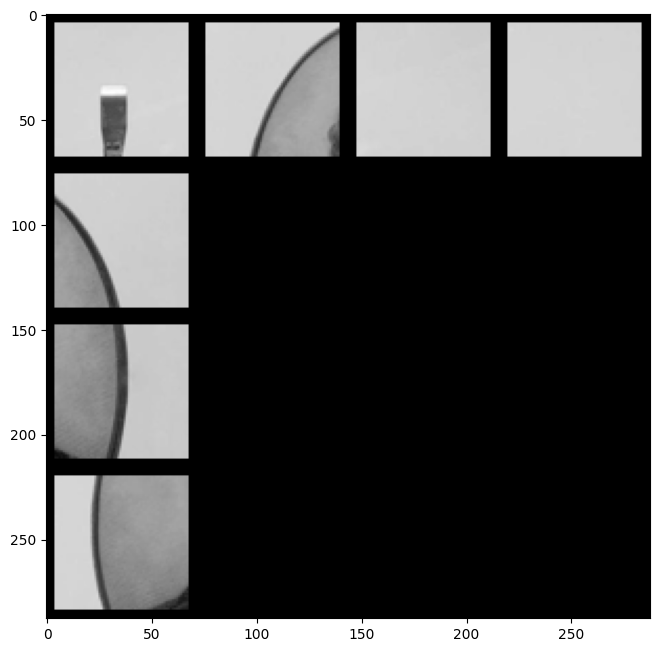

In [12]:
puz = nn_puzzle.squeeze().cpu().numpy().transpose(1,2,0)
puz = (puz - np.min(puz))/np.ptp(puz)
plt.imshow(puz)

In [13]:
args['conv_head'] = True
global VERBOSE
VERBOSE = False
args['p_weight_path']= None #'tb_logs/model_p_64-8-64-8-64_h0/version_4/checkpoints/epoch=41.ckpt'
#args['v_weight_path']='tb_logs/model_v_64-8-64-8-64_h8/version_0/checkpoints/model_v-epoch=030-val_loss=0.026.ckpt'
args['v_weight_path']= 'tb_logs/model_v_64-8-64-8-64_h0/version_2/checkpoints/model_v-epoch=009-val_loss=0.492.ckpt'
p_net, v_net = reassembly.prepare_nnets(args)


288 72 8
rdim: 512
rdim: 512
v weights loaded from tb_logs/model_v_64-8-64-8-64_h0/version_2/checkpoints/model_v-epoch=009-val_loss=0.492.ckpt


In [14]:
import torch
from lib.utils import sigmoid

In [15]:
tr = []
for i in range(9):
    solution_dicts[0]['position'] = i
    tr.append(g.pnet_input(solution_dicts, fragments, verbose=True))

[1, 2, 3, 4, 5, 6, 7, 8] [{'idx': 0, 'position': 0}, {'idx': 1, 'position': -1}, {'idx': 2, 'position': -1}, {'idx': 3, 'position': -1}, {'idx': 4, 'position': -1}, {'idx': 5, 'position': -1}, {'idx': 6, 'position': -1}, {'idx': 7, 'position': -1}, {'idx': 8, 'position': -1}]
[1, 2, 3, 4, 5, 6, 7, 8] [{'idx': 0, 'position': 1}, {'idx': 1, 'position': -1}, {'idx': 2, 'position': -1}, {'idx': 3, 'position': -1}, {'idx': 4, 'position': -1}, {'idx': 5, 'position': -1}, {'idx': 6, 'position': -1}, {'idx': 7, 'position': -1}, {'idx': 8, 'position': -1}]
[1, 2, 3, 4, 5, 6, 7, 8] [{'idx': 0, 'position': 2}, {'idx': 1, 'position': -1}, {'idx': 2, 'position': -1}, {'idx': 3, 'position': -1}, {'idx': 4, 'position': -1}, {'idx': 5, 'position': -1}, {'idx': 6, 'position': -1}, {'idx': 7, 'position': -1}, {'idx': 8, 'position': -1}]
[1, 2, 3, 4, 5, 6, 7, 8] [{'idx': 0, 'position': 3}, {'idx': 1, 'position': -1}, {'idx': 2, 'position': -1}, {'idx': 3, 'position': -1}, {'idx': 4, 'position': -1}, {'id

In [16]:
v_net(torch.cat(tr).cuda()).detach().cpu().numpy()

array([[0.44],
       [0.57],
       [0.66],
       [0.29],
       [0.55],
       [0.5 ],
       [0.28],
       [0.4 ],
       [0.58]], dtype=float32)

In [17]:
v_net(nn_puzzle)[0].detach().cpu().numpy()

array([0.72], dtype=float32)

In [18]:
bs = 16
x = []
y = []
m = []
for i in range(bs):
    u, v, w = data_v[i]
    x.append(u)
    y.append(v)
    m.append(w)
y = torch.tensor(np.array(y).squeeze()).cuda()

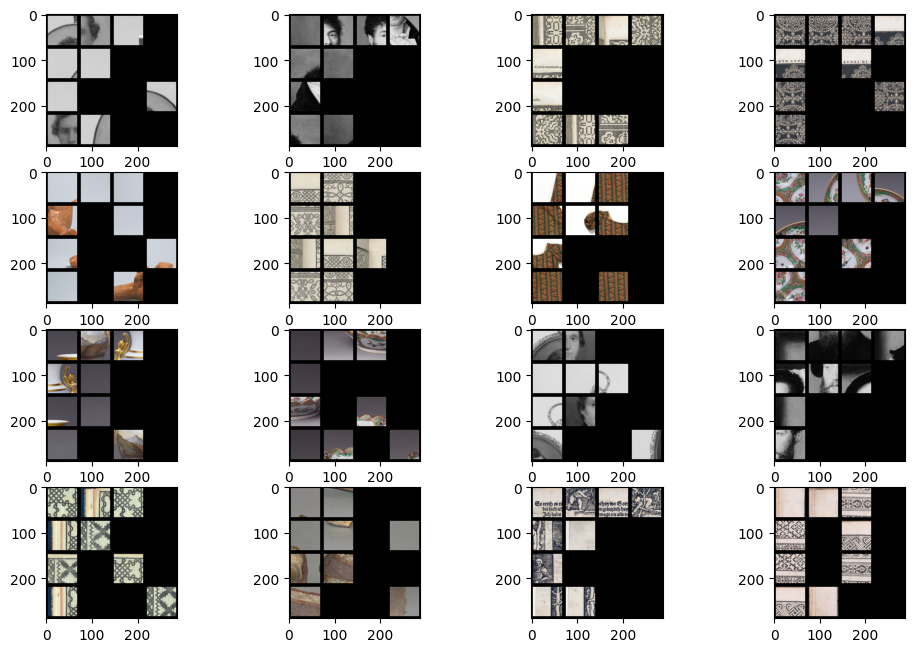

In [19]:
for i in range(min(bs, 16)):
    plt.subplot(4, 4, 1+i)
    plt.imshow(x[i].squeeze().transpose(1,2,0))

In [20]:
y

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')

In [21]:
y_ = v_net(torch.tensor(x).cuda(), torch.tensor(m).cuda()).squeeze()

In [22]:
y_

tensor([0.9084, 0.9220, 0.8953, 0.8320, 0.7503, 0.0135, 0.9532, 0.7931, 0.8968,
        0.2342, 0.6782, 0.3294, 0.0368, 0.2367, 0.8985, 0.9398],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

In [23]:
(y_>0.5).int()

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0',
       dtype=torch.int32)

In [24]:
((y_>0.5).float() == y).sum()/bs

tensor(0.9375, device='cuda:0')

In [25]:
((y_>0.5).float() == y)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True], device='cuda:0')